In [1]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

d:\PrivateProjects\WroclawWeatherPredictor\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [3]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01
DATA = './data/meteo_16.9_51.103333_2025-11-30_2015-12-31.csv' 

TARGET_FET = 'apparent_temperature'
DROP_FEATURES = ['date']

MODEL_NAME = 'model_v1_sequential'
SAVE_PATH = './models'

In [4]:
df = pd.read_csv(DATA)
df['date'] = pd.to_datetime(df['date'])

print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0_to_7cm |   soil_moisture_0_to_7cm |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------|
|  0 | 2015-12-31 23:00:00+00:00 |          -4.5345 |                71.9106 |               -8.90121 |            101

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86928 entries, 0 to 86927
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   date                       86928 non-null  datetime64[ns, UTC]
 1   temperature_2m             86928 non-null  float64            
 2   relative_humidity_2m       86928 non-null  float64            
 3   apparent_temperature       86928 non-null  float64            
 4   surface_pressure           86928 non-null  float64            
 5   wind_direction_10m         86928 non-null  float64            
 6   wind_speed_10m             86928 non-null  float64            
 7   soil_temperature_0_to_7cm  86928 non-null  float64            
 8   soil_moisture_0_to_7cm     86928 non-null  float64            
 9   rain                       86928 non-null  float64            
 10  dew_point_2m               86928 non-null  float64            
 11  sn

In [6]:
print(df.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count    86928.000000          86928.000000          86928.000000   
mean        10.807921             74.093322              8.398162   
std          8.345029             16.129293             10.011767   
min        -17.650000             20.787464            -22.915014   
25%          4.265500             63.028503              0.251547   
50%         10.500000             76.759320              7.666414   
75%         17.300000             87.584018             16.339340   
max         36.550000            100.000000             37.904636   

       surface_pressure  wind_direction_10m  wind_speed_10m  \
count      86928.000000        86928.000000    86928.000000   
mean        1001.472787          210.917203       12.196620   
std            8.660856           88.885712        6.454805   
min          968.225700            0.674022        0.000000   
25%          996.348800          139.987800        7.568566   


In [7]:
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

df_len = len(df)

train_end = int(df_len * (1 - TEST_SIZE - VAL_SIZE))
val_end = int(df_len * (1 - TEST_SIZE))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()


print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 52156
Validation size: 17386
Test size: 17386


In [8]:
scaler = StandardScaler()
feature_columns = [col for col in df.columns if col not in DROP_FEATURES]

scaler.fit(train_df[feature_columns])

train_df[feature_columns] = scaler.transform(train_df[feature_columns])
val_df[feature_columns] = scaler.transform(val_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

print(train_df.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count    5.215600e+04          5.215600e+04          5.215600e+04   
mean    -2.337778e-16         -3.144284e-16          1.100772e-16   
std      1.000010e+00          1.000010e+00          1.000010e+00   
min     -3.410484e+00         -3.306425e+00         -3.127033e+00   
25%     -7.846423e-01         -6.832239e-01         -8.150077e-01   
50%     -4.125331e-02          1.584903e-01         -7.222025e-02   
75%      7.800716e-01          8.383354e-01          7.931981e-01   
max      3.088174e+00          1.608547e+00          2.950255e+00   

       surface_pressure  wind_direction_10m  wind_speed_10m  \
count      5.215600e+04        5.215600e+04    5.215600e+04   
mean      -4.463575e-15        1.005408e-16    3.446724e-17   
std        1.000010e+00        1.000010e+00    1.000010e+00   
min       -3.836438e+00       -2.365298e+00   -1.887565e+00   
25%       -5.941484e-01       -7.951825e-01   -7.178599e-01   


In [9]:
def extract_Xy(dataframe):
    X = dataframe.drop(columns=DROP_FEATURES + [TARGET_FET])
    y = dataframe[TARGET_FET]
    return X, y

X_train, y_train = extract_Xy(train_df)
X_val, y_val = extract_Xy(val_df)
X_test, y_test = extract_Xy(test_df)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(52156, 12) (52156,)
(17386, 12) (17386,)
(17386, 12) (17386,)


In [10]:
model = tf.keras.Sequential(name=MODEL_NAME)
model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

print(model.summary())

Model: "model_v1_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
monitors = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=monitors)

Epoch 1/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0052 - mae: 0.0376 - val_loss: 0.0010 - val_mae: 0.0221 - learning_rate: 0.0100
Epoch 2/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0013 - mae: 0.0229 - val_loss: 5.7059e-04 - val_mae: 0.0149 - learning_rate: 0.0100
Epoch 3/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0010 - mae: 0.0207 - val_loss: 7.4567e-04 - val_mae: 0.0174 - learning_rate: 0.0100
Epoch 4/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 9.3641e-04 - mae: 0.0192 - val_loss: 0.0022 - val_mae: 0.0292 - learning_rate: 0.0100
Epoch 5/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.0197e-04 - mae: 0.0177 - val_loss: 0.0024 - val_mae: 0.0318 - learning_rate: 0.0100
Epoch 6/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.6145e-04 - mae: 0.0173 - val_loss: 7.2686e-04 - val_mae: 0.0151 - learning_rate: 0.0100
Epoch 7/100
1614/1630 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4906e-04 - mae: 0.0184
Epoch 7: ReduceLRO

In [12]:
os.makedirs(os.path.join(SAVE_PATH,MODEL_NAME), exist_ok=True)
model.save(os.path.join(SAVE_PATH, MODEL_NAME, 'model.keras'))
joblib.dump(scaler, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler.pkl'))

['./models\\model_v1_sequential\\scaler.pkl']

=== TRAINING ===


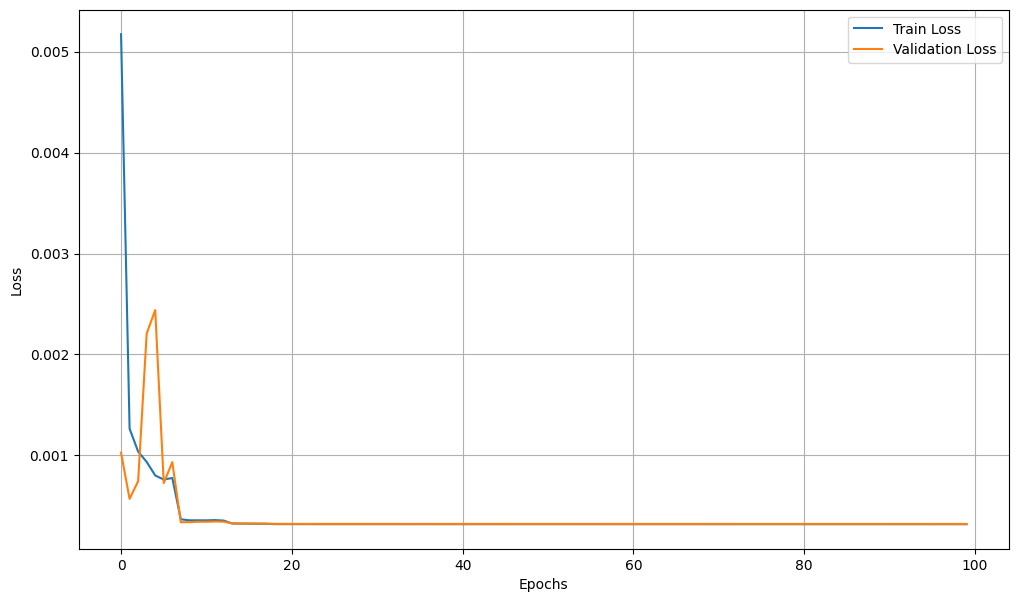

In [13]:
print("=== TRAINING ===")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
    

In [14]:
mae_scaled = model.evaluate(X_test, y_test)[1]

predictions = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(np.hstack((X_test, predictions)))[:, -1]
test_y_rescaled = scaler.inverse_transform(np.hstack((X_test, y_test.values.reshape(-1, 1))))[:, -1]

print()
print("=== TEST ===")

mae = np.mean(np.abs(pred_rescaled - test_y_rescaled))
print(f'Test MAE on scaled data: {mae_scaled:.3f}')
print(f'Test MAE rescaled to original values: {mae:.3f}')

print()

comp_tab = pd.DataFrame({
    'Data': test_df['date'].values,
    'Predicted': pred_rescaled,
    'Actual': test_y_rescaled
})
comp_tab = comp_tab.sort_values(by='Data')

print(tabulate(comp_tab, headers='keys', tablefmt='psql'))

544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3339e-04 - mae: 0.0072
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== TEST ===
Test MAE on scaled data: 0.007
Test MAE rescaled to original values: 0.280

+-------+---------------------+--------------+-------------+
|       | Data                |    Predicted |      Actual |
|-------+---------------------+--------------+-------------|
|  8713 | 2016-01-01 01:00:00 |  -0.845596   |  -0.961377  |
|  4661 | 2016-01-01 04:00:00 |   6.56706    |   6.44144   |
|  5757 | 2016-01-01 14:00:00 |  21.5948     |  21.5981    |
|   126 | 2016-01-01 17:00:00 |  17.2223     |  17.2114    |
|  3824 | 2016-01-01 19:00:00 |  12.6749     |  12.6518    |
|  4955 | 2016-01-01 21:00:00 |   8.84879    |   8.84616   |
|  4479 | 2016-01-02 01:00:00 |  -4.83484    |  -4.69605   |
|  9838 | 2016-01-02 03:00:00 | -12.2125     | -12.1606    |
|  7089 | 2016-01-02 11:00:00 | -21.2008     | -21.3266    |
|  8263 | 2016-01-02 12:00:00 | -19.2792     | -19.3971    |
| 